# Genome-Wide Association Study <a class="tocSkip"/>
# Chapter 1. Statistics Review of Regression- A toy example <a class="tocSkip"/>

This notebook demonstrates two basic statistical regression models using toy examples.

1. case/control study by logistic regression
2. quantitative trait study by linear regression

# Environment Setting and Packages

Before we can run any analysis, we need to load the necessary R packages. The list of packages are loaded with `library()` function.

<div class="alert alert-block alert-warning">
<b>Important: You need to load the libraries everytime you open this notebook!</b>
</div>

In [2]:
#load R packages
library(data.table)
library(GEOquery)
library(plyr)
library(ROCR)

ERROR: Error in library(GEOquery): there is no package called 'GEOquery'


# Toy Example Data

To illustrate the statistical methods, we will use a small dataset of 60 samples with both continuous and binary variables. This dataset is a microarray expression data downloaded from [GSE1378](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE1378). It contains 60 patients with ER-positive primary breast cancer treated with tamoxifen monotherapy for 5 years. We only extracted the recurrent status and gene expression of 3 genes to this toy example data. You can load this extracted data as below with `fread` function:

In [2]:
%use r
toy_data <- fread("chapter1_data/toy_example_data.txt")

We could take a view at the data. `head` function prints the first 6 rows of the dataset. `summary` function provides summary statistics of the numeric variables. Column `status` is a binary variable indicating whether the sample is recurrence or non-recurrence. The last three columns are expression of three genes HOXB13, IL17BR and NHLH1, so they are continuous. 

In [3]:
%use r
head(toy_data)
summary(toy_data)

sampleID,status,time,ratio_group,gene_HOXB13,gene_IL17BR,gene_NHLH1
<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
GSM22365,Status=recur,75,High HOXB13:IL17BR ratio,-2.8968509,-2.4744445,-0.121487242
GSM22366,Status=recur,21,High HOXB13:IL17BR ratio,-2.9811459,-2.1587305,-0.621517842
GSM22367,Status=recur,38,Low HOXB13:IL17BR ratio,-1.3201379,1.0535341,0.058391758
GSM22368,Status=recur,43,High HOXB13:IL17BR ratio,0.5141317,-1.7643865,0.007346758
GSM22369,Status=non-recur,169,Low HOXB13:IL17BR ratio,-3.0522629,0.8341051,-0.553806242
GSM22370,Status=recur,42,Low HOXB13:IL17BR ratio,-3.2735509,-0.9047099,0.842882758


   sampleID            status               time        ratio_group       
 Length:60          Length:60          Min.   :  5.00   Length:60         
 Class :character   Class :character   1st Qu.: 46.25   Class :character  
 Mode  :character   Mode  :character   Median : 88.00   Mode  :character  
                                       Mean   : 87.23                     
                                       3rd Qu.:124.25                     
                                       Max.   :169.00                     
  gene_HOXB13       gene_IL17BR        gene_NHLH1      
 Min.   :-3.8524   Min.   :-4.1248   Min.   :-1.27238  
 1st Qu.:-3.3163   1st Qu.:-1.4710   1st Qu.:-0.48316  
 Median :-2.9990   Median :-0.7511   Median :-0.20704  
 Mean   :-1.8780   Mean   :-0.6306   Mean   :-0.13142  
 3rd Qu.:-0.1243   3rd Qu.: 0.4623   3rd Qu.: 0.05158  
 Max.   : 3.3221   Max.   : 2.3773   Max.   : 1.98128  

We can also get a summary of the continuous expression variables by `status` groups. Below, we used `ddply` function to group the data by `status` and calculate `count`,`mean` and `sd` of the 3 genes in each group. As shown in the output data.frame, the `count` column indicates that there are 32 samples in non-recur and 28 in recur group respectively.

In [4]:
%use r
ddply(toy_data, ~status, summarise, count=length(gene_HOXB13), mean=mean(gene_HOXB13), sd=sd(gene_HOXB13))
ddply(toy_data, ~status, summarise, count=length(gene_IL17BR), mean=mean(gene_IL17BR), sd=sd(gene_IL17BR))
ddply(toy_data, ~status, summarise, count=length(gene_NHLH1), mean=mean(gene_NHLH1), sd=sd(gene_NHLH1))


status,count,mean,sd
<chr>,<int>,<dbl>,<dbl>
Status=non-recur,32,-2.8793163,1.243989
Status=recur,28,-0.7337302,2.320518


status,count,mean,sd
<chr>,<int>,<dbl>,<dbl>
Status=non-recur,32,-0.04768093,1.084837
Status=recur,28,-1.29686598,1.459527


status,count,mean,sd
<chr>,<int>,<dbl>,<dbl>
Status=non-recur,32,-0.1012933,0.6891341
Status=recur,28,-0.1658441,0.3837488


To prepare for logistic regression, we will create a `censor` variable as an indicator of the `status` group, with `1=recur` and `0=non-recur`. Later, we will use this binary `censor` variable and the last three columns of continuous expression variables of different genes to perform the analysis.

The codes below show you how to recode `status` into a binary variable `censor`. First, we get the index number of the recurrent status, and save them in `index` object. Then we create a new variable called `censor` and assign a sequnce of 0 to this vector. Next, we extract from `censor` the elements with index number in `index`, and assign/recode them as 1. After this recoding finishes, we again take a look at the first 6 rows with `head` function.

In [5]:
%use r
index <- which(toy_data$status=="Status=recur")
toy_data$censor <- rep(0,60)
toy_data$censor[index] <- 1
head(toy_data)

sampleID,status,time,ratio_group,gene_HOXB13,gene_IL17BR,gene_NHLH1,censor
<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GSM22365,Status=recur,75,High HOXB13:IL17BR ratio,-2.8968509,-2.4744445,-0.121487242,1
GSM22366,Status=recur,21,High HOXB13:IL17BR ratio,-2.9811459,-2.1587305,-0.621517842,1
GSM22367,Status=recur,38,Low HOXB13:IL17BR ratio,-1.3201379,1.0535341,0.058391758,1
GSM22368,Status=recur,43,High HOXB13:IL17BR ratio,0.5141317,-1.7643865,0.007346758,1
GSM22369,Status=non-recur,169,Low HOXB13:IL17BR ratio,-3.0522629,0.8341051,-0.553806242,0
GSM22370,Status=recur,42,Low HOXB13:IL17BR ratio,-3.2735509,-0.9047099,0.842882758,1


# Logistic Regression

Below is a simple case/control study on examing relationship between recurrence status and gene expression using logistic regression.

So what is logistic regression?

Logistic regression is the regression model to conduct when the dependent variable is dichotomous (binary). In this toy example, the binary dependent variable is recur/non-recur status. Similar to other regression methods, the logistic regression is a predictive analysis but it also reveals the association relationship between the dependent variable and the independent variables.

Logistic regression can help us answer a variety of questions, including, but not limited to the examples below:

1. How does the probability of getting lung cancer (yes vs. no) change for every additional pound of overweight and for every pack of cigarettes smoked per day?
2. Do body weight, calorie intake, fat intake, and participant age have an influence on heart attacks (yes vs. no)?

Mathematically,  the logistic regression equation can be defined as:

$l=log(\frac{p}{1-p}) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ...$, where $p$ is the probability that the response $Y=1$.


More detailed explanation about logistic regression can be found at: https://en.wikipedia.org/wiki/Logistic_regression

In the code below, we performed a logistic regression with a binary response `censor` and continuous expression of `gene_HOXB13`. The model is fitted with function `glm`. `cencor~gene_HOXB13` specifies the model structure, where `censor` is the response and `gene_HOCB13` is the explanatory variable. `family` argument specifies the distribution of `censor` as "binomial", and `link` sepecifies that link function for binomial response is "logit", which is why this model is called "logistic model".

In [6]:
%use r
# logistic regresion, use gene HOXB13 to predict the recur/non-recur status
# for significant gene: HOXB13
fit.logistic.1 <- glm(censor~ gene_HOXB13,data = toy_data,family = binomial(link = 'logit'))
summary(fit.logistic.1) # output summary of the logistic regression


Call:
glm(formula = censor ~ gene_HOXB13, family = binomial(link = "logit"), 
    data = toy_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0843  -0.8291  -0.7308   0.7810   1.7447  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.1904     0.5474   2.175 0.029655 *  
gene_HOXB13   0.6440     0.1913   3.366 0.000764 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 82.911  on 59  degrees of freedom
Residual deviance: 65.216  on 58  degrees of freedom
AIC: 69.216

Number of Fisher Scoring iterations: 4


The table under `Coefficients` contains test results. The pvalue of the gene HOXB13, in the last column of this table, is 0.000764 which is way smaller than 0.05. It indicates that this gene has a significant impact on the recurrence status.

## ROC curve and AUC for HOXB13

The ROC (receiver operating characteristic) curve and AUC (area under the curve) are popular tools to check the predictive ability of the logistic regression. 

Roughly speaking, the AUC equals to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. AUC is always between 0 and 1. The closer to 1 the AUC is, the better the model fits. As shown in the following results, the AUC is 0.796 and pretty close to 1. So this model fits the data well. In other words, we can say the expression of gene HOXB13 has a great explanation power on the recur status. 

For more information about these two concepts, Please visit: https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve


[1] 0.7957589

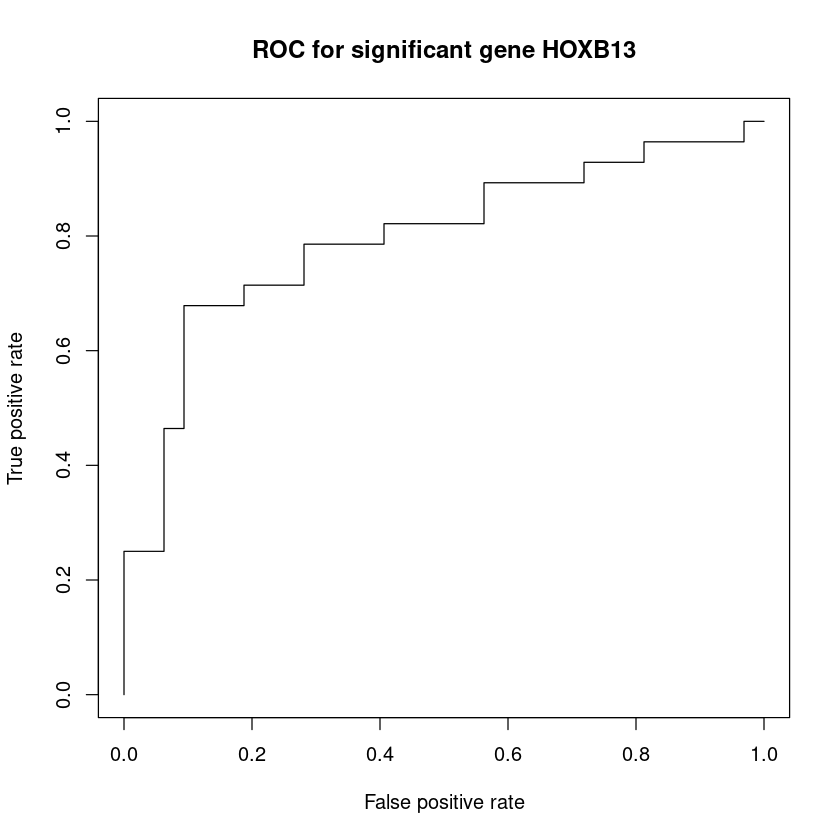

In [7]:
%use r
#plot ROC curve
p <- predict(fit.logistic.1, type="response")
pr <- prediction(p, toy_data$censor)
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
prf1 <- prf
plot(prf1,main="ROC for significant gene HOXB13")

# calculate the auc
auc <- performance(pr, measure = "auc")
auc <- auc@y.values[[1]]
auc # 0.796

## Practice

### Practice 1: Logistic regression

**We can repeat the same analysis using another gene, namely NHLH1. What can you conclude from the test results? Write several sentences to summarize.**

In [8]:
%use r
# for non-significant gene NHLH1
fit.logistic.2 <- glm(censor~ gene_NHLH1,data = toy_data,family = binomial(link = 'logit'))
summary(fit.logistic.2)


Call:
glm(formula = censor ~ gene_NHLH1, family = binomial(link = "logit"), 
    data = toy_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2220  -1.1323  -0.9953   1.2248   1.3238  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.1616     0.2672  -0.605    0.545
gene_NHLH1   -0.2089     0.4698  -0.445    0.657

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 82.911  on 59  degrees of freedom
Residual deviance: 82.710  on 58  degrees of freedom
AIC: 86.71

Number of Fisher Scoring iterations: 4


**Write your description here. (Double click to enable editing.)**

### Practice 2: ROC curve and AUC for NHLH1

**We draw the same ROC curve and calculate AUC for NHLH1, what can you conclude from results for NHLH1? Write several sentences to describe your conclusion.**

[1] 0.4709821

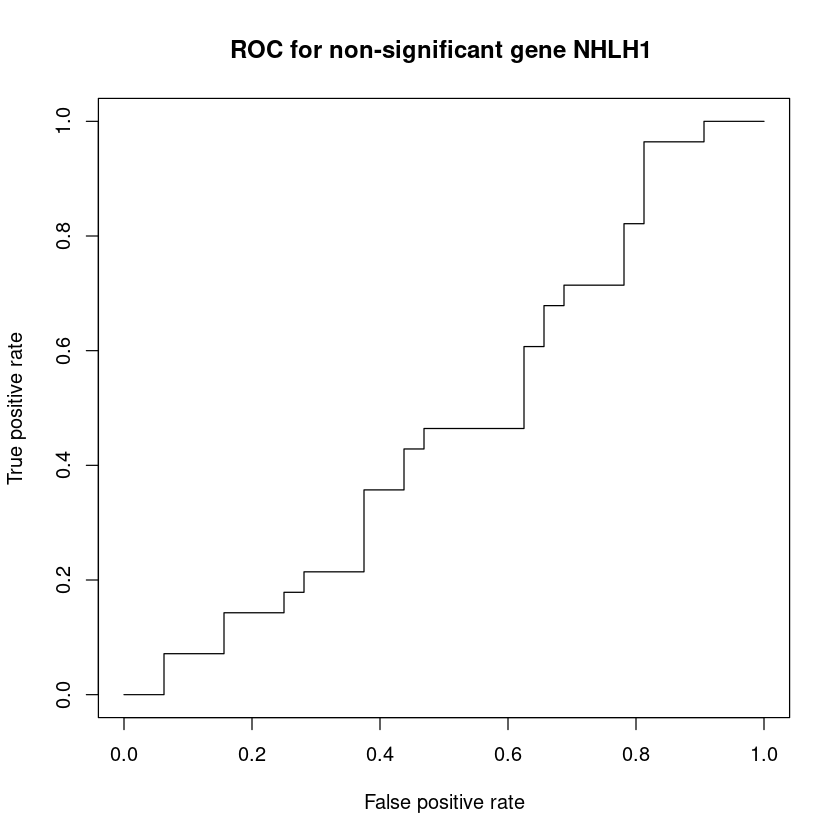

In [9]:
%use r
#plot ROC curve
p <- predict(fit.logistic.2, type="response")
pr <- prediction(p, toy_data$censor)
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
prf2 <- prf
plot(prf2,main="ROC for non-significant gene NHLH1 ")

# calculate the auc
auc <- performance(pr, measure = "auc")
auc <- auc@y.values[[1]]
auc

**Write your conclusion here. (Doble click to enable editing.)**

## Comparison of HOXB13 ROC curve and NHLH1 ROC curve

To have a direct compare the ROC curve for these 2 genes, we can plot the two ROC curves on a single plot. The code below generate the combined plot. We first plot ROC curve for HOXB13 as normal with color blue, then add the ROC curve of NHLH1 on this plot using `lines` and color red. `legend` function specifies the plot legend which is shown at the bottom of the plot.

With this combined plot, we can conclude that HOXB13 has much higher predictive probability than NHLH1, while retaining a low false positive rate..

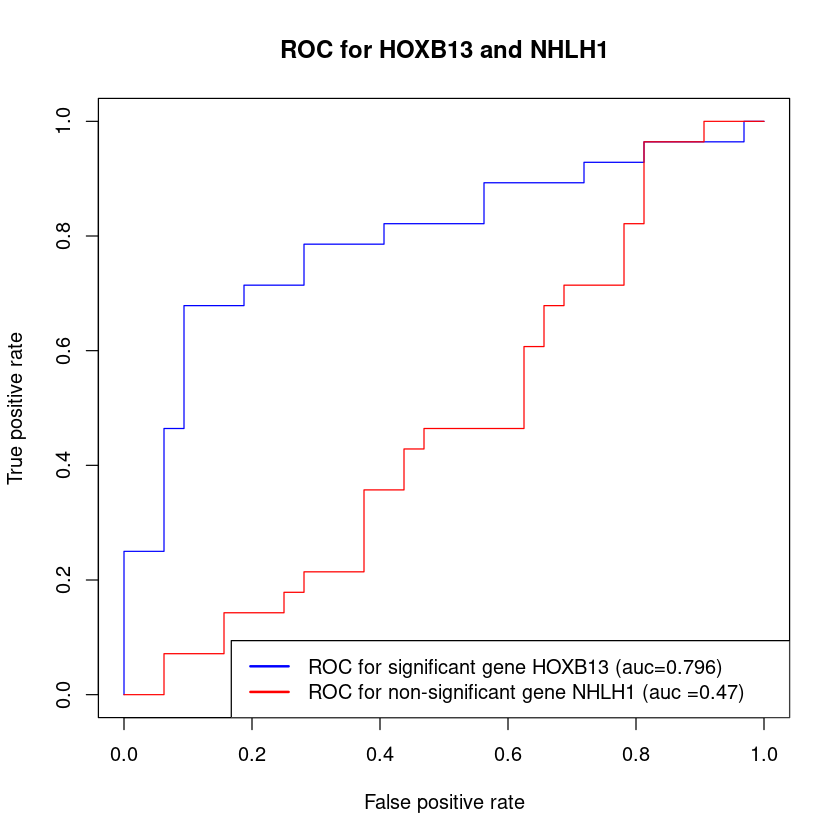

In [10]:
%use r
### two ROC curve comparison
plot(prf1,main="ROC for HOXB13 and NHLH1",col='blue')
lines(prf2@x.values[[1]],prf2@y.values[[1]],col='red')
legend('bottomright',lwd=2,
       legend=c("ROC for significant gene HOXB13 (auc=0.796)","ROC for non-significant gene NHLH1 (auc =0.47)"),
       col=c('blue','red'))

# Linear Regression

In statistics, **linear regression** is an approach for modeling the relationship between a continous dependent variable Y and one or more explanatory variables (or independent variables) denoted by X. The explanatory variables can be either continuous (e.g. age, weight) or categorical (e.g. gender, smoke or not).

In the following example, we examine the relationship between the expression of gene HOXB13 and IL17BR. Both of them are continous variables.

For more detailed explanation of linear regression, please visit: https://en.wikipedia.org/wiki/Linear_regression


## Linear regression of HOXB13 vs. IL17BR

Linear regression is fitted with `lm` function. The arguments in `lm` is very similar to those in `glm`, but much simpler as we don't need to specify the distribution and link function here.

In [11]:
%use r
# linear model, use gene IL17BR to predict another gene HOXB13
fit.lm <- lm(gene_HOXB13~gene_IL17BR,data = toy_data)
summary(fit.lm) # print the summary of the fitted regression


Call:
lm(formula = gene_HOXB13 ~ gene_IL17BR, data = toy_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5037 -1.5191 -0.6175  1.1574  5.3354 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -2.1772     0.2855  -7.626  2.6e-10 ***
gene_IL17BR  -0.4743     0.1861  -2.548   0.0135 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.016 on 58 degrees of freedom
Multiple R-squared:  0.1007,	Adjusted R-squared:  0.08519 
F-statistic: 6.494 on 1 and 58 DF,  p-value: 0.01349


The p-value for IL17BR is 0.0135<0.05, so there is a significant association between expression of HOXB13 and IL17BR.

Download an HTML copy of this Notebook with all outputs and your answers.

To save as an HTML, click `File`--`Download as`--`HTML(.html)` in the Jupyter Notebook menu bar.

# Quiz

<div class="alert alert-block alert-warning">
<b>Note: If you don't see quiz questions in this section, please click the current cell and click "Run" in the menu bar until you see the questions appear below.</b>
</div>


In [1]:
%use sos
runfile("/anvil/projects/x-tra220018/2023/quiz/quiz_func.py")
runfile("/anvil/projects/x-tra220018/2023/quiz/unit3/chapter1.py")